<a href="https://colab.research.google.com/github/sedaoturak/VAE_Mechanical_MNIST/blob/main/VAE_mechanical_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd.variable import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm.notebook

# Load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/Case1_input_patterns_64_x_64.txt', 'r') as f: 
  g = np.loadtxt(f)
with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/Case1_strain_energy.txt', 'r') as f:
  e = np.loadtxt(f)

Mounted at /content/drive


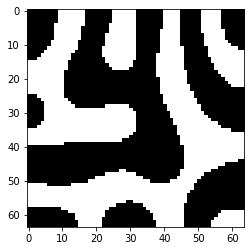

In [3]:
# visualize an image from dataset
img = g.reshape(37523,64,64)
plt.imshow(img[9,:,:], interpolation='nearest', cmap='binary')
plt.show()

In [17]:
# normalize the strain energy values
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
scaler = MinMaxScaler(feature_range=(0,1))

e_scaled = scaler.fit_transform(e[:,6].reshape(-1, 1))
e_power = pt.fit_transform(e[:,6].reshape(-1, 1))
e_power_scaled = scaler.fit_transform(e_power)
e_scaled.shape, e_scaled.ravel().shape

images = g.reshape((37523,64,64))
energies = e_power_scaled.ravel()

images.shape, energies.shape

((37523, 64, 64), (37523,))

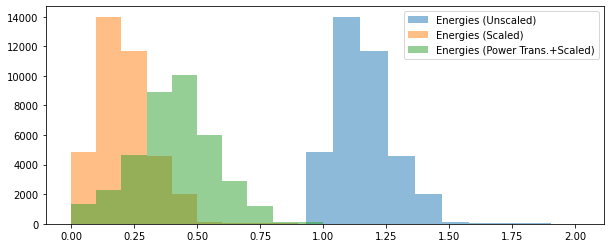

In [18]:
fig, axs = plt.subplots(figsize=(10,4))

axs.hist(e[:,6], label=f'Energies (Unscaled)', alpha=0.5)
axs.hist(e_scaled, label=f'Energies (Scaled)', alpha=0.5)
# axs.hist(e_power, label=f'Energies (Power Trans.)', alpha=0.5)
axs.hist(e_power_scaled, label=f'Energies (Power Trans.+Scaled)', alpha=0.5)
axs.legend()

In [53]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
  def __init__(self, imgs, labels, transform):
    self.labels = labels
    self.imgs = imgs
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    if self.labels is None:
      x = self.imgs[index]
      x = self.transform(x)
      return x
    else:
      x = self.imgs[index]
      x = self.transform(x)
      y = self.labels[index]
    return x, y

b, w, h, = [*images.shape]
print(images.shape)
images_wb = np.repeat(images[..., np.newaxis], 1, -1)
print(images_wb.shape)
images_wb = images_wb.reshape(b, 1, w, h)
print(images_wb.shape)

(37523, 64, 64)
(37523, 64, 64, 1)
(37523, 1, 64, 64)


In [54]:
transform = transforms.Compose([
      # transforms.Resize((32, 32)),
        ])

# Datasets
normalized_images = images_wb
data = torch.tensor(normalized_images, dtype=torch.float32)
target = torch.tensor(energies, dtype=torch.float32).reshape(-1,1)

if __name__ == "__main__":
  dataset = CustomDataset(data, target, transform)

In [55]:
# train-test split
train_set_size = int(len(dataset)*0.8)
val_set_size = len(dataset) - train_set_size

trainset, valset  = random_split(dataset, [train_set_size, val_set_size])
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers= 2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers= 2)

# Model

In [121]:
kernel_size = 4
init_channels = 16
image_channels = 1
latent_dim = 16

class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(in_channels=image_channels, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.enc2 = nn.Conv2d(in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.enc3 = nn.Conv2d(in_channels=init_channels*8, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.enc4 = nn.Conv2d(in_channels=init_channels*8, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0)
        self.dropout = nn.Dropout(0.25)
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0)
        self.dec2 = nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.dec3 = nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.dec4 = nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.dec5 = nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1)
    def encoder(self, x):
        x = F.relu(self.enc1(x))
        x = self.dropout(x)
        x = F.relu(self.enc2(x))
        # x = self.dropout(x)
        x = F.relu(self.enc3(x))
        # x = self.dropout(x)
        x = F.relu(self.enc4(x))
        # x = self.dropout(x)
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        return hidden

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # 'randn_like' as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def decoder(self,z):
        x = F.relu(self.dec1(z))
        # x = self.dropout(x)
        x = F.relu(self.dec2(x))
        # x = self.dropout(x)
        x = F.relu(self.dec3(x))
        # x = self.dropout(x)
        x = F.relu(self.dec4(x))
        x = self.dropout(x)
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction
 
    def forward(self, x):
        hidden = self.encoder(x)
        # get 'mu' and 'log_var'
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        x = self.fc2(z)
        x = x.view(-1, 64, 1, 1)
        out = self.decoder(x)
        return z, mu, log_var, out

In [122]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction='mean')

In [123]:
from tqdm import tqdm

torch.backends.cudnn.benchmark = True

def final_loss(mse_loss, beta, mu, logvar):
    BCE = mse_loss 
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
    return BCE + beta*KLD

def train(dataloader, dataset, beta):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, (data,target) in tqdm(enumerate(dataloader)):
        counter += 1
        data = data.to(device)
        optimizer.zero_grad(set_to_none=True)

        z, mu, logvar, out = model(data)
        bce_loss = criterion(out, data)
        loss = final_loss(bce_loss, beta, mu, logvar)

        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return z, train_loss

def validate(dataloader, dataset, beta):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, (data,target) in tqdm(enumerate(dataloader)):
            counter += 1
            data = data.to(device)
            z, mu, logvar, out = model(data)
            bce_loss = criterion(out, data)
            loss = final_loss(bce_loss, beta, mu, logvar)
            running_loss += loss.item()
        
    val_loss = running_loss / counter
    return z, val_loss

In [ ]:
epochs = 100

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    # beta annealing
    if epoch<30:
      beta=0
    else:
      beta=1e-4

    ztrain, train_epoch_loss = train(trainloader, trainset, beta)
    zval, valid_epoch_loss = validate(valloader, valset, beta)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

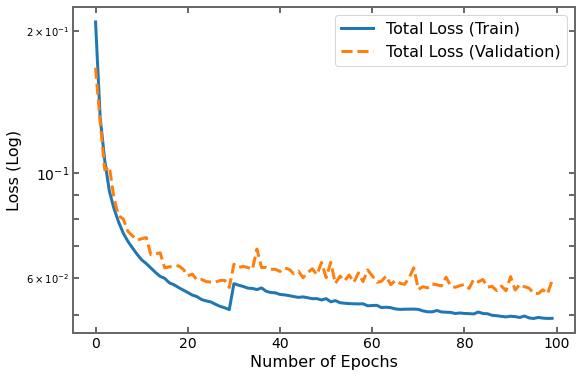

In [89]:
fig, ax = plt.subplots(figsize=(9, 6))
font_size=16
tick_size=14

ax.plot(train_loss, '-', label='Total Loss (Train)', linewidth=3)
ax.plot(valid_loss,'--', label='Total Loss (Validation)', linewidth=3)

ax.set_ylabel('Loss (Log)', fontsize=font_size)
ax.set_xlabel('Number of Epochs', fontsize=font_size)
ax.set_yscale('log', basey=10)

ax.xaxis.set_tick_params(width=2, length=5, labelsize=tick_size, color='dimgrey')
ax.yaxis.set_tick_params(width=2, length=5, labelsize=tick_size, color='dimgrey')
ax.tick_params(which='both', width=2, length=6, top=True, right=True, direction='in', color='dimgrey')
plt.setp(ax.spines.values(), linewidth=2, color='dimgrey')
ax.legend(fontsize=font_size)

In [ ]:
# save model
import os
PATH = '/content/drive/MyDrive/'
# torch.save(model, PATH+'mech_MNIST_ls16')

model_scripted = torch.jit.script(model.cpu())
model_scripted.save(os.path.join(PATH, f'mech_MNIST_ls16-scripted.pt'))
torch.save(model.state_dict(), PATH)

In [ ]:
# load trained model
PATH = '/content/drive/MyDrive/'
model = torch.load(PATH+'mech_MNIST_ls16')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reconstructed Images

In [126]:
original_images = []
reconstructed_images = []
z_train = np.zeros((0,16))
strain_energy = np.zeros((0,1))
for i, (d,t) in tqdm(enumerate(trainloader)):
  d = d.to(device)
  z, _, _, out = model(d)
  original_images.append(d.cpu().detach().numpy())
  reconstructed_images.append(out.cpu().detach().numpy())
  z_train = np.vstack([z_train,z.cpu().detach().numpy()])
  strain_energy = np.vstack([strain_energy, t.cpu().detach().numpy()])
strain_energy = strain_energy.ravel()

470it [00:05, 85.45it/s] 


Text(-10, 52, 'Reconstruction')

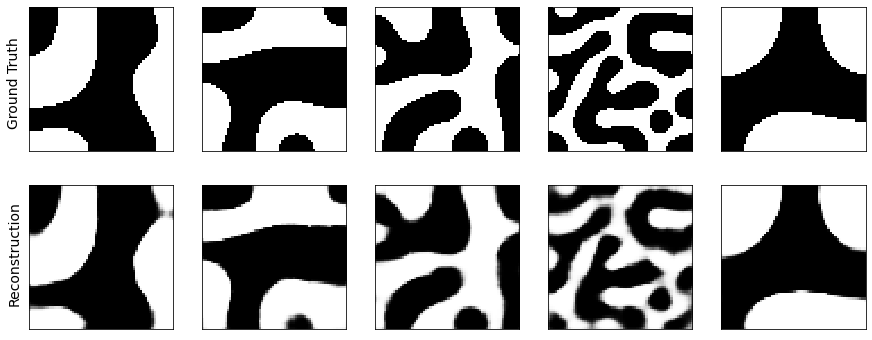

In [132]:
f, axs = plt.subplots(2,5, figsize=(15,6))
for i, ind in enumerate(np.random.randint(0,64,5)):
  axs[0,i].imshow(original_images[0].reshape(64,64,64)[ind,:,:], interpolation='nearest', cmap='binary')
  axs[0,i].axes.xaxis.set_visible(False)
  axs[0,i].axes.yaxis.set_visible(False)
  axs[1,i].imshow(reconstructed_images[0].reshape(64,64,64)[ind,:,:], interpolation='nearest', cmap='binary')
  axs[1,i].axes.xaxis.set_visible(False)
  axs[1,i].axes.yaxis.set_visible(False)

axs[0,0].text(-10, 52, 'Ground Truth', fontsize=14, rotation=90)
axs[1,0].text(-10, 52, 'Reconstruction', fontsize=14, rotation=90)

# Latent Space

In [133]:
# decrease the dimensionality of latent space from 16 to 2 to visualize
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_projected = pca.fit_transform(z_train)

z_train_labels = [e[indx,6] for indx in trainset.indices]

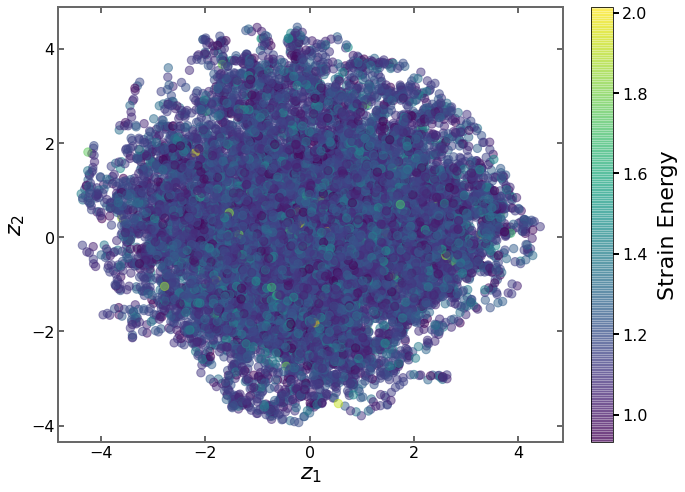

In [134]:
z = z_projected

fig, ax = plt.subplots(figsize=(10, 8))
font_size=22
tick_size=16

sc = ax.scatter(*z.T, s=70, c=z_train_labels, cmap='viridis', alpha=0.5)

ax.set_xlabel("$z_{1}$", fontsize=font_size)
ax.set_ylabel("$z_{2}$", fontsize=font_size)

plt.setp(ax.spines.values(), linewidth=2, color='dimgrey')
ax.xaxis.set_tick_params(width=2, color='dimgrey')
ax.yaxis.set_tick_params(width=2, color='dimgrey')
ax.tick_params(direction='in', length=6, labelsize=tick_size, 
              top=True, right=True)

cbar = plt.colorbar(sc,fraction=0.045, pad=0.05)
cbar.set_label(label='Strain Energy', labelpad=10, size=font_size)
cbar.ax.tick_params(length=6, width=2,labelsize=tick_size)

In [ ]:
import plotly.graph_objects as go

z = z_projected

fig = go.Figure(data=[go.Scatter(
                                  x = z[:,0], 
                                  y = z[:,1],
                                  mode = 'markers',
                                  marker = dict(color= z_train_labels,
                                                colorscale='Viridis', 
                                                size=12, 
                                                opacity=0.5, 
                                                colorbar=dict(thickness=12)))
])
fig.update_layout(height=500, width=600, showlegend=False, 
                  margin=dict(l=70,r=50,b=70,t=50),
                  xaxis_title="$z_{1}$",
                  yaxis_title="$z_{2}$",
                       font=dict(
                           size=14
                           )
                  )
fig.show()